# Yelp Review Prediction - Baseline Models
**Author:** Ben

**Project:** Capstone - Star Rating Prediction

**Objective:** Train and evaluate baseline models (Random Forest and XGBoost) to predict star ratings from review text and metadata

---

## Model Approach

**Research Question:** How do traditional ML models (Random Forest, XGBoost) perform on star rating prediction when combining text features with business metadata?

**Models Selected:**
1. **Random Forest**: Ensemble method robust to overfitting, handles non-linear relationships
2. **XGBoost**: High-performance gradient boosting that natively supports sparse matrices and parallelization

**Features:**
- Text: TF-IDF vectors (top 5000 terms)
- Metadata: Business category, location, review length, engagement metrics, temporal features

**Evaluation:**
- Accuracy, Precision, Recall, F1-score (per class and macro average)
- Confusion matrices
- Feature importance analysis
- Error analysis

## 1. Setup and Load Data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import pickle
import os

# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)
from sklearn.model_selection import cross_val_score
from scipy import sparse

# XGBoost import
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

# Set visualization defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Create directories
os.makedirs('../Outputs/Models', exist_ok=True)
os.makedirs('../Outputs/Plots', exist_ok=True)

print("Libraries imported successfully")
print(f"Current time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ Libraries imported successfully
Current time: 2026-01-21 17:42:03


In [26]:
# Load cleaned data
print("Loading cleaned datasets...\n")

# Start with sample for rapid prototyping
USE_SAMPLE = False  # Set to False to use full dataset

if USE_SAMPLE:
    print("Loading SAMPLE dataset (50k rows) for rapid iteration...")
    train_df = pd.read_csv('../Data/Processed/yelp_sample.csv')
    # Create a small test set from sample
    from sklearn.model_selection import train_test_split
    train_df, test_df = train_test_split(train_df, test_size=0.2, 
                                         random_state=42, stratify=train_df['stars'])
    print(f"Sample loaded: {len(train_df):,} train, {len(test_df):,} test")
else:
    print("Loading FULL dataset...")
    train_df = pd.read_csv('../Data/Processed/yelp_train.csv')
    test_df = pd.read_csv('../Data/Processed/yelp_test.csv')
    print(f"Full data loaded: {len(train_df):,} train, {len(test_df):,} test")

print(f"\nTrain shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# Verify target distribution
print("\nTarget distribution (train):")
print(train_df['stars'].value_counts(normalize=True).sort_index())

Loading cleaned datasets...

Loading FULL dataset...
✓ Full data loaded: 2,000,000 train, 500,000 test

Train shape: (2000000, 25)
Test shape: (500000, 25)

Target distribution (train):
stars
1    0.2
2    0.2
3    0.2
4    0.2
5    0.2
Name: proportion, dtype: float64


## 2. Feature Engineering

In [27]:
# Extract target variable
y_train = train_df['stars'].values
y_test = test_df['stars'].values

print(f"Target variable extracted:")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Classes: {np.unique(y_train)}")

Target variable extracted:
  y_train shape: (2000000,)
  y_test shape: (500000,)
  Classes: [1 2 3 4 5]


In [50]:
# Text Feature Extraction - TF-IDF
print("=" * 80)
print("TEXT FEATURE EXTRACTION (TF-IDF)")
print("=" * 80)

print("\nFitting TF-IDF vectorizer on training data...")
start_time = datetime.now()

tfidf = TfidfVectorizer(
    max_features=7000,      # Limit to top 5000 terms
    min_df=5,               # Term must appear in at least 5 documents
    max_df=0.85,             # Ignore terms in more than 80% of documents
    ngram_range=(1, 2),     # Use unigrams and bigrams
    stop_words='english',   # Remove common English stop words
    lowercase=True,
    strip_accents='unicode'
)

# Fit on training data and transform both train and test
X_train_text = tfidf.fit_transform(train_df['text'].fillna(''))
X_test_text = tfidf.transform(test_df['text'].fillna(''))

elapsed = (datetime.now() - start_time).total_seconds()
print(f"TF-IDF completed in {elapsed:.1f} seconds")
print(f"\nTF-IDF feature dimensions:")
print(f"Train: {X_train_text.shape}")
print(f"Test: {X_test_text.shape}")
print(f"Vocabulary size: {len(tfidf.vocabulary_)}")
print(f"Sparsity: {(1.0 - X_train_text.nnz / (X_train_text.shape[0] * X_train_text.shape[1])):.1%}")

TEXT FEATURE EXTRACTION (TF-IDF)

Fitting TF-IDF vectorizer on training data...
✓ TF-IDF completed in 212.3 seconds

TF-IDF feature dimensions:
  Train: (2000000, 7000)
  Test: (500000, 7000)
  Vocabulary size: 7000
  Sparsity: 99.4%


In [51]:
# Show top TF-IDF terms
print("\nTop 20 TF-IDF terms by average score:")
feature_names = tfidf.get_feature_names_out()
avg_tfidf = np.asarray(X_train_text.mean(axis=0)).flatten()
top_indices = avg_tfidf.argsort()[-20:][::-1]

for i, idx in enumerate(top_indices, 1):
    print(f"{i:2d}. {feature_names[idx]:20s} (avg score: {avg_tfidf[idx]:.4f})")


Top 20 TF-IDF terms by average score:
   1. food                 (avg score: 0.0308)
   2. good                 (avg score: 0.0281)
   3. place                (avg score: 0.0253)
   4. great                (avg score: 0.0239)
   5. service              (avg score: 0.0220)
   6. just                 (avg score: 0.0199)
   7. like                 (avg score: 0.0193)
   8. time                 (avg score: 0.0192)
   9. really               (avg score: 0.0156)
  10. got                  (avg score: 0.0139)
  11. order                (avg score: 0.0136)
  12. nice                 (avg score: 0.0135)
  13. ve                   (avg score: 0.0133)
  14. ordered              (avg score: 0.0132)
  15. don                  (avg score: 0.0132)
  16. staff                (avg score: 0.0127)
  17. chicken              (avg score: 0.0121)
  18. best                 (avg score: 0.0116)
  19. restaurant           (avg score: 0.0116)
  20. didn                 (avg score: 0.0115)


In [52]:
# Metadata Feature Engineering
print("\n" + "=" * 80)
print("METADATA FEATURE ENGINEERING")
print("=" * 80)

def extract_metadata_features(df, encoders=None, fit=True):
    """
    Extract and encode metadata features from the dataframe.
    
    Args:
        df: Input dataframe
        encoders: Dictionary of fitted encoders (for test set)
        fit: Whether to fit encoders (True for train, False for test)
    
    Returns:
        features: Numpy array of features
        encoders: Dictionary of encoders (if fit=True)
    """
    features_list = []
    feature_names = []
    
    if encoders is None:
        encoders = {}
    
    # 1. Numerical features (already scaled by nature)
    numerical_features = [
        'word_count',
        'char_count', 
        'useful',
        'funny',
        'cool',
        'total_engagement',
        'review_count',
        'user_review_count'
    ]
    
    for col in numerical_features:
        if col in df.columns:
            values = df[col].fillna(0).values.reshape(-1, 1)
            
            if fit:
                scaler = StandardScaler()
                scaled_values = scaler.fit_transform(values)
                encoders[f'{col}_scaler'] = scaler
            else:
                scaled_values = encoders[f'{col}_scaler'].transform(values)
            
            features_list.append(scaled_values)
            feature_names.append(col)
    
    # 2. Binary features
    binary_features = ['is_open']
    for col in binary_features:
        if col in df.columns:
            features_list.append(df[col].fillna(1).values.reshape(-1, 1))
            feature_names.append(col)
    
    # 3. Temporal features
    temporal_features = ['year', 'month', 'day_of_week']
    for col in temporal_features:
        if col in df.columns:
            values = df[col].fillna(df[col].mode()[0] if len(df[col].mode()) > 0 else 0).values.reshape(-1, 1)
            features_list.append(values)
            feature_names.append(col)
    
    # 4. Categorical features - State (top 10 only)
    if 'state' in df.columns:
        if fit:
            top_states = df['state'].value_counts().head(10).index.tolist()
            encoders['top_states'] = top_states
        else:
            top_states = encoders['top_states']
        
        # Create binary features for top states
        for state in top_states:
            features_list.append((df['state'] == state).astype(int).values.reshape(-1, 1))
            feature_names.append(f'state_{state}')
    
    # 5. Categories - Extract top categories
    if 'categories' in df.columns:
        if fit:
            # Find most common categories
            all_cats = []
            for cats in df['categories'].fillna('').str.split(', '):
                all_cats.extend(cats)
            from collections import Counter
            top_categories = [cat for cat, _ in Counter(all_cats).most_common(20) if cat]
            encoders['top_categories'] = top_categories
        else:
            top_categories = encoders['top_categories']
        
        # Create binary features for top categories
        for category in top_categories:
            has_category = df['categories'].fillna('').str.contains(category, case=False, regex=False)
            features_list.append(has_category.astype(int).values.reshape(-1, 1))
            feature_names.append(f'category_{category.replace(" ", "_")}')
    
    # 6. User activity level
    if 'user_activity' in df.columns:
        activity_mapping = {
            '1 review': 1,
            '2-5 reviews': 2,
            '6-20 reviews': 3,
            '21-100 reviews': 4,
            '100+ reviews': 5
        }
        activity_encoded = df['user_activity'].map(activity_mapping).fillna(1).values.reshape(-1, 1)
        features_list.append(activity_encoded)
        feature_names.append('user_activity_level')
    
    # Combine all features
    X_metadata = np.hstack(features_list)
    
    if fit:
        return X_metadata, encoders, feature_names
    else:
        return X_metadata, feature_names

# Extract features
print("\nExtracting metadata features...")
X_train_meta, metadata_encoders, metadata_feature_names = extract_metadata_features(train_df, fit=True)
X_test_meta, _ = extract_metadata_features(test_df, encoders=metadata_encoders, fit=False)

print(f"\nMetadata features extracted")
print(f"Train shape: {X_train_meta.shape}")
print(f"Test shape: {X_test_meta.shape}")
print(f"Number of metadata features: {len(metadata_feature_names)}")
print(f"\nMetadata feature names:")
for i, name in enumerate(metadata_feature_names[:20], 1):  # Show first 20
    print(f"{i:2d}. {name}")
if len(metadata_feature_names) > 20:
    print(f"... and {len(metadata_feature_names) - 20} more")


METADATA FEATURE ENGINEERING

Extracting metadata features...

✓ Metadata features extracted
  Train shape: (2000000, 43)
  Test shape: (500000, 43)
  Number of metadata features: 43

Metadata feature names:
   1. word_count
   2. char_count
   3. useful
   4. funny
   5. cool
   6. total_engagement
   7. review_count
   8. user_review_count
   9. is_open
  10. year
  11. month
  12. day_of_week
  13. state_PA
  14. state_FL
  15. state_LA
  16. state_TN
  17. state_MO
  18. state_IN
  19. state_AZ
  20. state_NV
  ... and 23 more


In [53]:
# Combine text and metadata features
print("\n" + "=" * 80)
print("COMBINING FEATURES")
print("=" * 80)

# Convert metadata to sparse matrix for efficient storage
X_train_meta_sparse = sparse.csr_matrix(X_train_meta)
X_test_meta_sparse = sparse.csr_matrix(X_test_meta)

# Combine text (TF-IDF) and metadata
X_train_combined = sparse.hstack([X_train_text, X_train_meta_sparse])
X_test_combined = sparse.hstack([X_test_text, X_test_meta_sparse])

print(f"\nFeatures combined")
print(f"Text features: {X_train_text.shape[1]}")
print(f"Metadata features: {X_train_meta.shape[1]}")
print(f"Total features: {X_train_combined.shape[1]}")
print(f"\nFinal feature matrices:")
print(f"X_train shape: {X_train_combined.shape}")
print(f"X_test shape: {X_test_combined.shape}")


COMBINING FEATURES

✓ Features combined
  Text features: 7000
  Metadata features: 43
  Total features: 7043

Final feature matrices:
  X_train shape: (2000000, 7043)
  X_test shape: (500000, 7043)


## 3. Baseline Model - Most Frequent Class

In [54]:
# Calculate baseline accuracy (always predict most frequent class)
print("=" * 80)
print("BASELINE MODEL - MOST FREQUENT CLASS")
print("=" * 80)

most_frequent_class = pd.Series(y_train).value_counts().idxmax()
baseline_predictions = np.full(len(y_test), most_frequent_class)
baseline_accuracy = accuracy_score(y_test, baseline_predictions)

print(f"\nMost frequent class: {int(most_frequent_class)} stars")
print(f"Baseline accuracy (always predict {int(most_frequent_class)} stars): {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
print(f"\nThis is our minimum performance threshold - any model must beat {baseline_accuracy:.1%}")

BASELINE MODEL - MOST FREQUENT CLASS

Most frequent class: 5 stars
Baseline accuracy (always predict 5 stars): 0.2000 (20.00%)

This is our minimum performance threshold - any model must beat 20.0%


## 4. Model Training - Random Forest

In [55]:
# Train Random Forest - Text Only
print("=" * 80)
print("RANDOM FOREST - TEXT ONLY")
print("=" * 80)

print("\nTraining Random Forest on text features only...")
start_time = datetime.now()

rf_text = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_text.fit(X_train_text, y_train)

training_time = (datetime.now() - start_time).total_seconds()
print(f"\nTraining completed in {training_time:.1f} seconds ({training_time/60:.1f} minutes)")

# Predictions
y_pred_rf_text = rf_text.predict(X_test_text)

# Metrics
rf_text_accuracy = accuracy_score(y_test, y_pred_rf_text)
rf_text_f1_macro = f1_score(y_test, y_pred_rf_text, average='macro')

print(f"\nPerformance:")
print(f"Accuracy: {rf_text_accuracy:.4f} ({rf_text_accuracy*100:.2f}%)")
print(f"F1-Score (macro): {rf_text_f1_macro:.4f}")
print(f"Improvement over baseline: +{(rf_text_accuracy - baseline_accuracy)*100:.2f}%")

RANDOM FOREST - TEXT ONLY

Training Random Forest on text features only...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.



✓ Training completed in 241.4 seconds (4.0 minutes)

Performance:
  Accuracy: 0.5147 (51.47%)
  F1-Score (macro): 0.4971
  Improvement over baseline: +31.47%


[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.4s finished


In [56]:
# Train Random Forest - Text + Metadata
print("\n" + "=" * 80)
print("RANDOM FOREST - TEXT + METADATA")
print("=" * 80)

print("\nTraining Random Forest on combined features (text + metadata)...")
start_time = datetime.now()

rf_combined = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_combined.fit(X_train_combined, y_train)

training_time = (datetime.now() - start_time).total_seconds()
print(f"\nTraining completed in {training_time:.1f} seconds ({training_time/60:.1f} minutes)")

# Predictions
y_pred_rf_combined = rf_combined.predict(X_test_combined)

# Metrics
rf_combined_accuracy = accuracy_score(y_test, y_pred_rf_combined)
rf_combined_f1_macro = f1_score(y_test, y_pred_rf_combined, average='macro')

print(f"\nPerformance:")
print(f"Accuracy: {rf_combined_accuracy:.4f} ({rf_combined_accuracy*100:.2f}%)")
print(f"F1-Score (macro): {rf_combined_f1_macro:.4f}")
print(f"Improvement over text-only: +{(rf_combined_accuracy - rf_text_accuracy)*100:.2f}%")
print(f"Improvement over baseline: +{(rf_combined_accuracy - baseline_accuracy)*100:.2f}%")


RANDOM FOREST - TEXT + METADATA

Training Random Forest on combined features (text + metadata)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.2min finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.



✓ Training completed in 315.1 seconds (5.3 minutes)

Performance:
  Accuracy: 0.5263 (52.63%)
  F1-Score (macro): 0.5120
  Improvement over text-only: +1.16%
  Improvement over baseline: +32.63%


[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.5s finished


## 5. Model Training - XGBoost

In [57]:
# Train XGBoost - Text + Metadata
print("=" * 80)
print("XGBOOST - TEXT + METADATA")
print("=" * 80)

print("\nTraining XGBoost on combined features...")
start_time = datetime.now()

from xgboost import XGBClassifier

gbm = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,  # Use all CPU cores
    tree_method='hist',  # Faster histogram-based algorithm
    verbosity=1
)

# XGBoost handles sparse matrices natively - no conversion needed!
# Note: XGBoost expects classes to be 0-indexed, so we need to subtract 1
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

gbm.fit(X_train_combined, y_train_xgb)

training_time = (datetime.now() - start_time).total_seconds()
print(f"\nTraining completed in {training_time:.1f} seconds ({training_time/60:.1f} minutes)")

# Predictions (convert back to 1-5 scale)
y_pred_gbm = gbm.predict(X_test_combined) + 1

# Metrics
gbm_accuracy = accuracy_score(y_test, y_pred_gbm)
gbm_f1_macro = f1_score(y_test, y_pred_gbm, average='macro')

print(f"\nPerformance:")
print(f"Accuracy: {gbm_accuracy:.4f} ({gbm_accuracy*100:.2f}%)")
print(f"F1-Score (macro): {gbm_f1_macro:.4f}")
print(f"Improvement over RF combined: {(gbm_accuracy - rf_combined_accuracy)*100:+.2f}%")
print(f"Improvement over baseline: +{(gbm_accuracy - baseline_accuracy)*100:.2f}%")

XGBOOST - TEXT + METADATA

Training XGBoost on combined features...
⚠️  XGBoost natively supports sparse matrices - much faster than sklearn GBM!

✓ Training completed in 276.2 seconds (4.6 minutes)

Performance:
  Accuracy: 0.5382 (53.82%)
  F1-Score (macro): 0.5316
  Improvement over RF combined: +1.19%
  Improvement over baseline: +33.82%


## 6. Model Comparison

In [58]:
# Create comprehensive comparison
print("=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)

# Store all results
results = {
    'Model': [
        'Baseline (Most Frequent)',
        'Random Forest (Text Only)',
        'Random Forest (Text + Metadata)',
        'XGBoost (Text + Metadata)'
    ],
    'Accuracy': [
        baseline_accuracy,
        rf_text_accuracy,
        rf_combined_accuracy,
        gbm_accuracy
    ],
    'F1 (Macro)': [
        0.0,  # Baseline has no real F1
        rf_text_f1_macro,
        rf_combined_f1_macro,
        gbm_f1_macro
    ]
}

results_df = pd.DataFrame(results)
print("\n", results_df.to_string(index=False))

# Key insights
metadata_improvement = rf_combined_accuracy - rf_text_accuracy
best_model = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
best_accuracy = results_df['Accuracy'].max()

print(f"\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)
print(f"\n1. Adding metadata improves accuracy by: {metadata_improvement*100:+.2f}%")
print(f"2. Best model: {best_model}")
print(f"3. Best accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"4. Total improvement over baseline: {(best_accuracy - baseline_accuracy)*100:.2f}%")

MODEL COMPARISON SUMMARY

                           Model  Accuracy  F1 (Macro)
       Baseline (Most Frequent)  0.200000    0.000000
      Random Forest (Text Only)  0.514678    0.497080
Random Forest (Text + Metadata)  0.526280    0.511989
      XGBoost (Text + Metadata)  0.538152    0.531650

KEY FINDINGS

1. Adding metadata improves accuracy by: +1.16%
2. Best model: XGBoost (Text + Metadata)
3. Best accuracy: 0.5382 (53.82%)
4. Total improvement over baseline: 33.82%


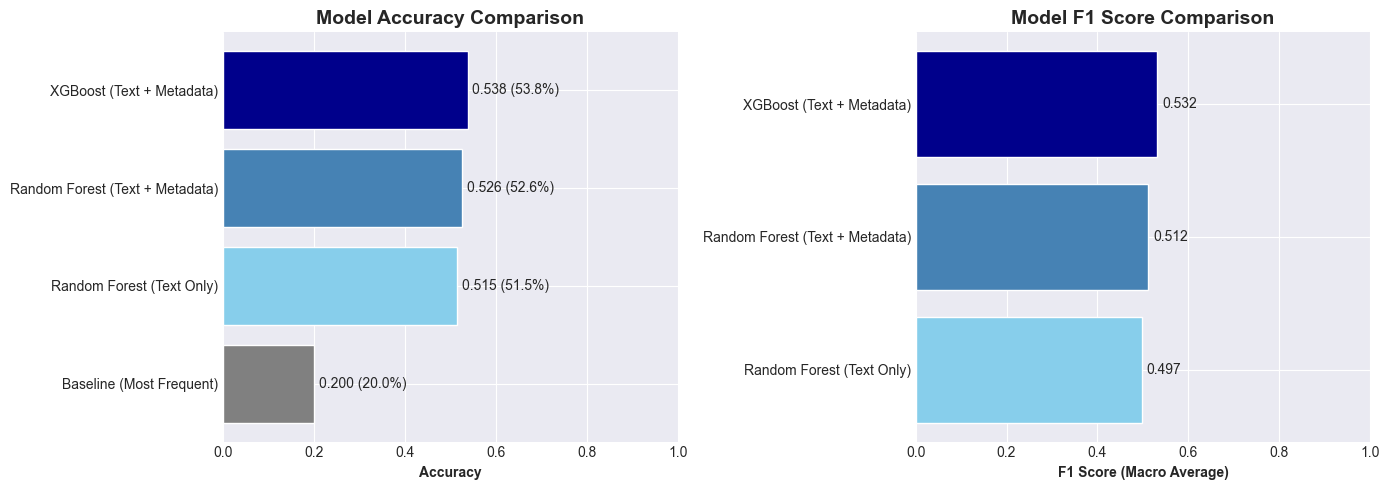

✓ Plot saved: 08_model_comparison.png


In [59]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].barh(results_df['Model'], results_df['Accuracy'], color=['gray', 'skyblue', 'steelblue', 'darkblue'])
axes[0].set_xlabel('Accuracy', fontweight='bold')
axes[0].set_title('Model Accuracy Comparison', fontweight='bold', fontsize=14)
axes[0].set_xlim(0, 1)

# Add value labels
for i, v in enumerate(results_df['Accuracy']):
    axes[0].text(v + 0.01, i, f'{v:.3f} ({v*100:.1f}%)', va='center')

# F1 Score comparison (excluding baseline)
results_df_no_baseline = results_df[results_df['Model'] != 'Baseline (Most Frequent)']
axes[1].barh(results_df_no_baseline['Model'], results_df_no_baseline['F1 (Macro)'], 
            color=['skyblue', 'steelblue', 'darkblue'])
axes[1].set_xlabel('F1 Score (Macro Average)', fontweight='bold')
axes[1].set_title('Model F1 Score Comparison', fontweight='bold', fontsize=14)
axes[1].set_xlim(0, 1)

# Add value labels
for i, v in enumerate(results_df_no_baseline['F1 (Macro)']):
    axes[1].text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.savefig('../Outputs/Plots/08_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: 08_model_comparison.png")

## 7. Detailed Performance Metrics

In [60]:
# Classification reports for each model
print("=" * 80)
print("DETAILED CLASSIFICATION REPORTS")
print("=" * 80)

models_for_report = [
    ('Random Forest (Text Only)', y_pred_rf_text),
    ('Random Forest (Text + Metadata)', y_pred_rf_combined),
    ('XGBoost (Text + Metadata)', y_pred_gbm)
]

for model_name, y_pred in models_for_report:
    print(f"\n{'='*80}")
    print(f"{model_name}")
    print('='*80)
    print(classification_report(y_test, y_pred, 
                                target_names=['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']))

DETAILED CLASSIFICATION REPORTS

Random Forest (Text Only)
              precision    recall  f1-score   support

      1 Star       0.58      0.78      0.67    100000
     2 Stars       0.49      0.32      0.38    100000
     3 Stars       0.47      0.38      0.42    100000
     4 Stars       0.47      0.37      0.41    100000
     5 Stars       0.52      0.74      0.61    100000

    accuracy                           0.51    500000
   macro avg       0.50      0.51      0.50    500000
weighted avg       0.50      0.51      0.50    500000


Random Forest (Text + Metadata)
              precision    recall  f1-score   support

      1 Star       0.59      0.78      0.67    100000
     2 Stars       0.50      0.31      0.38    100000
     3 Stars       0.47      0.40      0.43    100000
     4 Stars       0.48      0.44      0.46    100000
     5 Stars       0.54      0.70      0.61    100000

    accuracy                           0.53    500000
   macro avg       0.52      0.53      

In [61]:
# Per-class metrics comparison
print("\n" + "=" * 80)
print("PER-CLASS PERFORMANCE COMPARISON")
print("=" * 80)

# Calculate per-class metrics for best model (XGBoost)
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_gbm)

per_class_df = pd.DataFrame({
    'Star Rating': [1, 2, 3, 4, 5],
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nXGBoost - Per-Class Metrics:")
print(per_class_df.to_string(index=False))

# Identify hardest class
hardest_class = per_class_df.loc[per_class_df['F1-Score'].idxmin(), 'Star Rating']
hardest_f1 = per_class_df.loc[per_class_df['F1-Score'].idxmin(), 'F1-Score']
easiest_class = per_class_df.loc[per_class_df['F1-Score'].idxmax(), 'Star Rating']
easiest_f1 = per_class_df.loc[per_class_df['F1-Score'].idxmax(), 'F1-Score']

print(f"\nKey Observations:")
print(f"Hardest to predict: {int(hardest_class)}-star reviews (F1: {hardest_f1:.3f})")
print(f"Easiest to predict: {int(easiest_class)}-star reviews (F1: {easiest_f1:.3f})")
print(f"Performance gap: {(easiest_f1 - hardest_f1):.3f}")


PER-CLASS PERFORMANCE COMPARISON

XGBoost - Per-Class Metrics:
 Star Rating  Precision  Recall  F1-Score  Support
           1   0.617134 0.74967  0.676976   100000
           2   0.469102 0.39163  0.426880   100000
           3   0.478110 0.40526  0.438681   100000
           4   0.467530 0.49259  0.479733   100000
           5   0.621078 0.65161  0.635978   100000

Key Observations:
  Hardest to predict: 2-star reviews (F1: 0.427)
  Easiest to predict: 1-star reviews (F1: 0.677)
  Performance gap: 0.250


## 8. Confusion Matrices

CONFUSION MATRICES


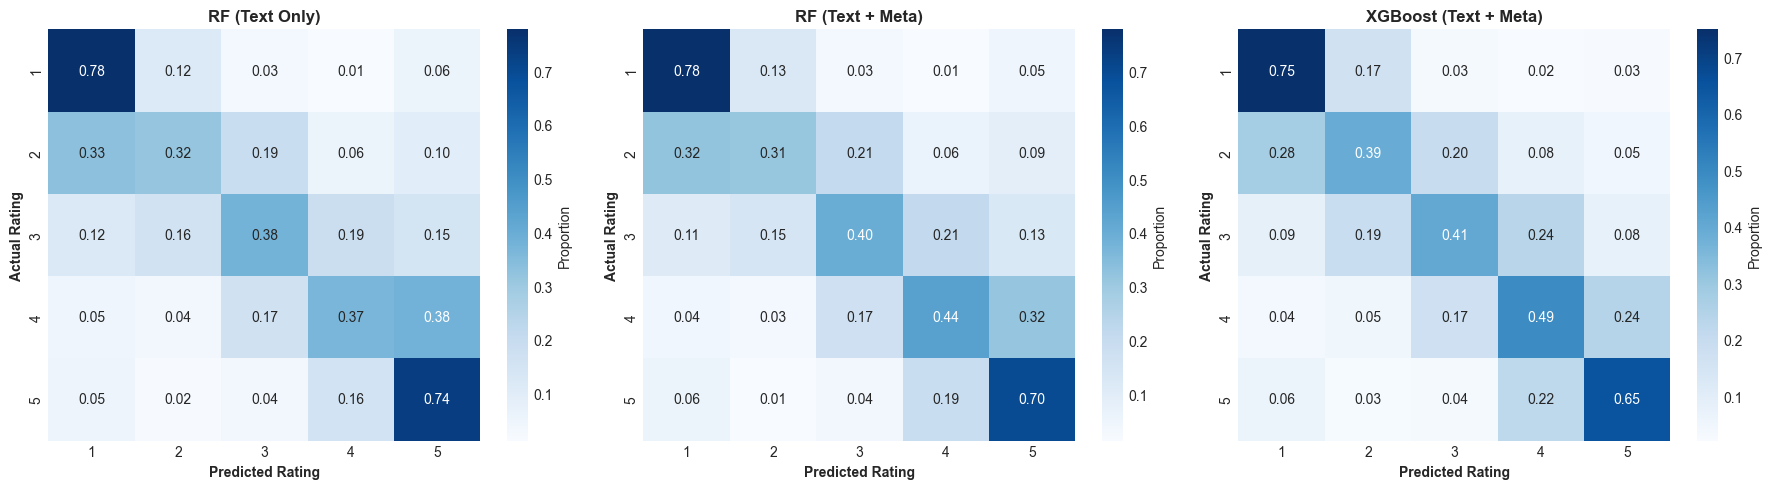

✓ Plot saved: 09_confusion_matrices.png


In [62]:
# Generate confusion matrices
print("=" * 80)
print("CONFUSION MATRICES")
print("=" * 80)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_for_cm = [
    ('RF (Text Only)', y_pred_rf_text),
    ('RF (Text + Meta)', y_pred_rf_combined),
    ('XGBoost (Text + Meta)', y_pred_gbm)
]

for idx, (model_name, y_pred) in enumerate(models_for_cm):
    cm = confusion_matrix(y_test, y_pred)
    
    # Normalize for better visualization
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
               xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5],
               ax=axes[idx], cbar_kws={'label': 'Proportion'})
    axes[idx].set_xlabel('Predicted Rating', fontweight='bold')
    axes[idx].set_ylabel('Actual Rating', fontweight='bold')
    axes[idx].set_title(f'{model_name}', fontweight='bold')

plt.tight_layout()
plt.savefig('../Outputs/Plots/09_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: 09_confusion_matrices.png")

In [63]:
# Analyze confusion patterns
print("\n" + "=" * 80)
print("CONFUSION MATRIX ANALYSIS (Best Model: XGBoost)")
print("=" * 80)

cm = confusion_matrix(y_test, y_pred_gbm)

print("\nRaw confusion matrix:")
print("Predicted")
print("Actual   1   2   3   4   5")
for i, row in enumerate(cm, 1):
    print(f"  {i}   {row[0]:5d} {row[1]:5d} {row[2]:5d} {row[3]:5d} {row[4]:5d}")

# Calculate key confusion patterns
print("\nKey confusion patterns:")
for actual in range(5):
    # Off-by-one errors (predicting 3 when actual is 4, etc.)
    if actual > 0:
        off_by_one_lower = cm[actual, actual-1]
    else:
        off_by_one_lower = 0
    
    if actual < 4:
        off_by_one_upper = cm[actual, actual+1]
    else:
        off_by_one_upper = 0
    
    correct = cm[actual, actual]
    total = cm[actual, :].sum()
    off_by_one_total = off_by_one_lower + off_by_one_upper
    
    print(f"\n{actual+1} star reviews:")
    print(f"Correctly predicted: {correct}/{total} ({correct/total*100:.1f}%)")
    print(f"Off by 1 star: {off_by_one_total}/{total} ({off_by_one_total/total*100:.1f}%)")
    print(f"Off by 2+ stars: {total-correct-off_by_one_total}/{total} ({(total-correct-off_by_one_total)/total*100:.1f}%)")


CONFUSION MATRIX ANALYSIS (Best Model: XGBoost)

Raw confusion matrix:
         Predicted
Actual   1★   2★   3★   4★   5★
  1★   74967 16930  3330  2174  2599
  2★   27812 39163 19895  8139  4991
  3★    8699 19252 40526 23612  7911
  4★    3816  5189 17482 49259 24254
  5★    6182  2951  3530 22176 65161

Key confusion patterns:

  1★ reviews:
    Correctly predicted: 74967/100000 (75.0%)
    Off by 1 star: 16930/100000 (16.9%)
    Off by 2+ stars: 8103/100000 (8.1%)

  2★ reviews:
    Correctly predicted: 39163/100000 (39.2%)
    Off by 1 star: 47707/100000 (47.7%)
    Off by 2+ stars: 13130/100000 (13.1%)

  3★ reviews:
    Correctly predicted: 40526/100000 (40.5%)
    Off by 1 star: 42864/100000 (42.9%)
    Off by 2+ stars: 16610/100000 (16.6%)

  4★ reviews:
    Correctly predicted: 49259/100000 (49.3%)
    Off by 1 star: 41736/100000 (41.7%)
    Off by 2+ stars: 9005/100000 (9.0%)

  5★ reviews:
    Correctly predicted: 65161/100000 (65.2%)
    Off by 1 star: 22176/100000 (22.2%

## 9. Feature Importance Analysis

In [64]:
# Feature importance for Random Forest
print("=" * 80)
print("FEATURE IMPORTANCE ANALYSIS - RANDOM FOREST")
print("=" * 80)

# Get feature importances
importances = rf_combined.feature_importances_

# Create feature names (TF-IDF terms + metadata)
all_feature_names = list(feature_names) + metadata_feature_names

# Create dataframe
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop 30 Most Important Features:")
print(importance_df.head(30).to_string(index=False))

# Separate text vs metadata importance
n_text_features = len(feature_names)
text_importance = importances[:n_text_features].sum()
metadata_importance = importances[n_text_features:].sum()

print(f"\n" + "="*80)
print("IMPORTANCE BY FEATURE TYPE")
print("="*80)
print(f"\nTotal importance from text features: {text_importance:.4f} ({text_importance*100:.1f}%)")
print(f"Total importance from metadata: {metadata_importance:.4f} ({metadata_importance*100:.1f}%)")
print(f"\nText features are {text_importance/metadata_importance:.1f}x more important than metadata")

FEATURE IMPORTANCE ANALYSIS - RANDOM FOREST

Top 30 Most Important Features:
             Feature  Importance
               great    0.043575
   user_review_count    0.033955
                good    0.029257
           delicious    0.027715
               worst    0.026120
 user_activity_level    0.025947
             amazing    0.024904
                told    0.019450
                best    0.017198
        review_count    0.016318
category_Restaurants    0.016044
                said    0.015176
                cool    0.014653
                rude    0.013633
              called    0.013248
            horrible    0.012661
          definitely    0.012358
            terrible    0.012047
                year    0.011883
                  ok    0.011721
            friendly    0.011592
               money    0.011294
             manager    0.011180
              highly    0.010840
          word_count    0.010799
              pretty    0.010692
           excellent    0.010167

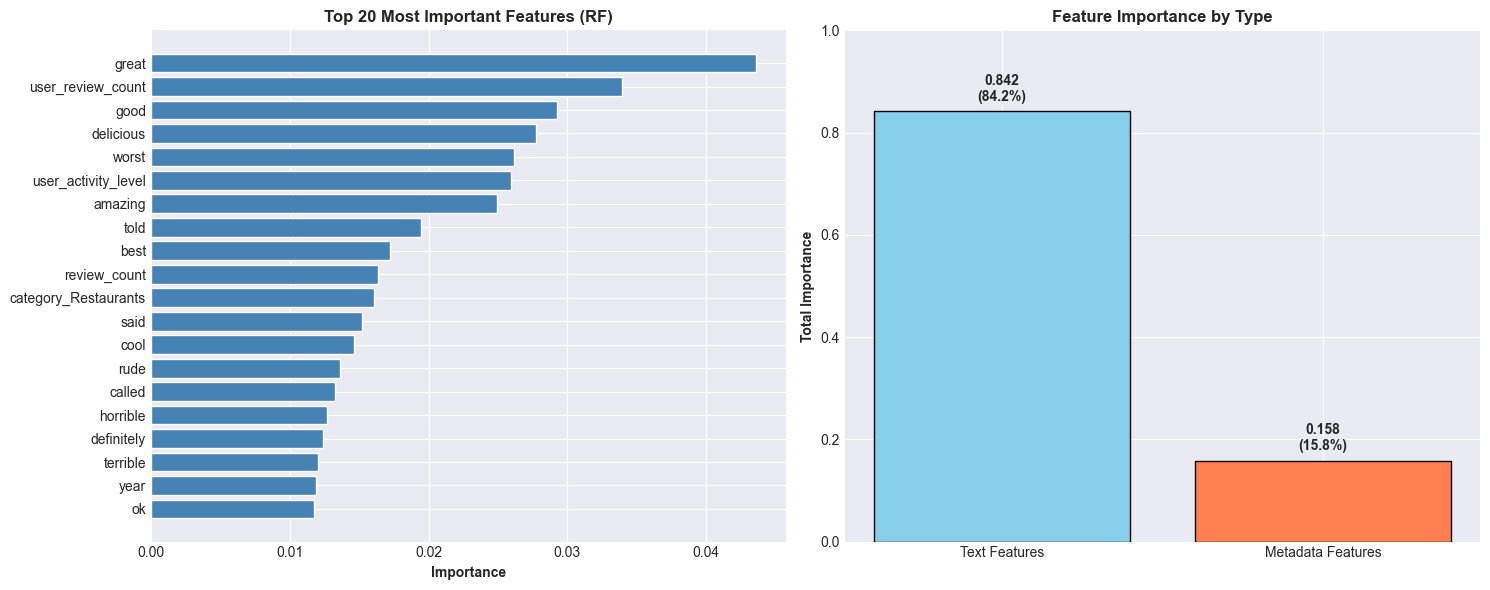

✓ Plot saved: 10_feature_importance.png


In [65]:
# Visualize top features
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Top 20 overall features
top_20 = importance_df.head(20)
axes[0].barh(range(20), top_20['Importance'].values[::-1], color='steelblue')
axes[0].set_yticks(range(20))
axes[0].set_yticklabels(top_20['Feature'].values[::-1])
axes[0].set_xlabel('Importance', fontweight='bold')
axes[0].set_title('Top 20 Most Important Features (RF)', fontweight='bold', fontsize=12)

# Text vs Metadata importance
importance_by_type = pd.DataFrame({
    'Type': ['Text Features', 'Metadata Features'],
    'Total Importance': [text_importance, metadata_importance]
})

axes[1].bar(importance_by_type['Type'], importance_by_type['Total Importance'], 
           color=['skyblue', 'coral'], edgecolor='black')
axes[1].set_ylabel('Total Importance', fontweight='bold')
axes[1].set_title('Feature Importance by Type', fontweight='bold', fontsize=12)
axes[1].set_ylim(0, 1)

# Add value labels
for i, v in enumerate(importance_by_type['Total Importance']):
    axes[1].text(i, v + 0.02, f'{v:.3f}\n({v*100:.1f}%)', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../Outputs/Plots/10_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: 10_feature_importance.png")

## 10. Error Analysis

In [66]:
# Error analysis - find worst predictions
print("=" * 80)
print("ERROR ANALYSIS")
print("=" * 80)

# Create error analysis dataframe
test_df_copy = test_df.copy().reset_index(drop=True)
test_df_copy['predicted'] = y_pred_gbm
test_df_copy['actual'] = y_test
test_df_copy['error'] = test_df_copy['predicted'] - test_df_copy['actual']
test_df_copy['abs_error'] = abs(test_df_copy['error'])
test_df_copy['correct'] = test_df_copy['predicted'] == test_df_copy['actual']

# Overall error statistics
print("\nOverall Error Statistics:")
print(f"Correct predictions: {test_df_copy['correct'].sum():,} ({test_df_copy['correct'].mean()*100:.2f}%)")
print(f"Incorrect predictions: {(~test_df_copy['correct']).sum():,} ({(~test_df_copy['correct']).mean()*100:.2f}%)")
print(f"\nMean absolute error: {test_df_copy['abs_error'].mean():.3f} stars")
print(f"Median absolute error: {test_df_copy['abs_error'].median():.1f} stars")

# Error by magnitude
print("\nError by Magnitude:")
for error in range(0, 5):
    count = (test_df_copy['abs_error'] == error).sum()
    pct = count / len(test_df_copy) * 100
    print(f"  Off by {error} stars: {count:,} ({pct:.1f}%)")

# Error by actual rating
print("\nAccuracy by Actual Star Rating:")
for star in [1, 2, 3, 4, 5]:
    mask = test_df_copy['actual'] == star
    accuracy = test_df_copy[mask]['correct'].mean()
    count = mask.sum()
    print(f"  {star} star: {accuracy*100:.1f}% correct ({count:,} reviews)")

ERROR ANALYSIS

Overall Error Statistics:
  Correct predictions: 269,076 (53.82%)
  Incorrect predictions: 230,924 (46.18%)

  Mean absolute error: 0.644 stars
  Median absolute error: 0.0 stars

Error by Magnitude:
  Off by 0 stars: 269,076 (53.8%)
  Off by 1 stars: 171,413 (34.3%)
  Off by 2 stars: 36,798 (7.4%)
  Off by 3 stars: 13,932 (2.8%)
  Off by 4 stars: 8,781 (1.8%)

Accuracy by Actual Star Rating:
  1★: 75.0% correct (100,000 reviews)
  2★: 39.2% correct (100,000 reviews)
  3★: 40.5% correct (100,000 reviews)
  4★: 49.3% correct (100,000 reviews)
  5★: 65.2% correct (100,000 reviews)


In [67]:
# Show specific error examples
print("\n" + "=" * 80)
print("EXAMPLE MISCLASSIFICATIONS")
print("=" * 80)

# Extreme errors (predicted 5, actual 1 and vice versa)
print("\n" + "="*80)
print("EXTREME ERRORS (Predicted 5★, Actual 1★)")
print("="*80)
extreme_errors_5_1 = test_df_copy[(test_df_copy['predicted'] == 5) & (test_df_copy['actual'] == 1)]
if len(extreme_errors_5_1) > 0:
    for idx, row in extreme_errors_5_1.head(3).iterrows():
        print(f"\nExample {idx+1}:")
        print(f"Review: {row['text'][:300]}...")
        print(f"Word count: {row['word_count']}")
        if 'categories' in row:
            print(f"Category: {row['categories'][:50]}...")
else:
    print("No examples found")

print("\n" + "="*80)
print("EXTREME ERRORS (Predicted 1 star, Actual 5 star)")
print("="*80)
extreme_errors_1_5 = test_df_copy[(test_df_copy['predicted'] == 1) & (test_df_copy['actual'] == 5)]
if len(extreme_errors_1_5) > 0:
    for idx, row in extreme_errors_1_5.head(3).iterrows():
        print(f"\nExample {idx+1}:")
        print(f"Review: {row['text'][:300]}...")
        print(f"Word count: {row['word_count']}")
        if 'categories' in row:
            print(f"  Category: {row['categories'][:50]}...")
else:
    print("No examples found")

# 3-star confusion (predicted 2 or 4, actual 3)
print("\n" + "="*80)
print("3-STAR CONFUSION (Actual 3 star, but predicted 2 star or 4 star)")
print("="*80)
three_star_errors = test_df_copy[(test_df_copy['actual'] == 3) & 
                                 (test_df_copy['predicted'].isin([2, 4]))]
if len(three_star_errors) > 0:
    for idx, row in three_star_errors.head(3).iterrows():
        print(f"\nExample {idx+1}: Predicted {int(row['predicted'])}★, Actual {int(row['actual'])}★")
        print(f"Review: {row['text'][:300]}...")
        print(f"Word count: {row['word_count']}")
else:
    print("No examples found")


EXAMPLE MISCLASSIFICATIONS

EXTREME ERRORS (Predicted 5★, Actual 1★)

Example 401:
  Review: This restaurant used to be amazing! I've been back twice now and will not go back again. The food is over priced, bland and the portions are small. The wait staff are good though....
  Word count: 34
  Category: Afghan, Food, Breweries, Brasseries, Restaurants, ...

Example 557:
  Review: I would not recommend this facility to anyone.  I had problems when trying to provide music to their residents, especially to a man who had no arms or legs, and I was completely let down by their staff.  In my opinion, a good administrative staff includes people who don't lie and who don't put up wi...
  Word count: 201
  Category: Rehabilitation Center, Health & Medical...

Example 637:
  Review: My wife and I have not eaten here for quite some time.....last night we did....and NEVER again will we! 
Warm at best, reheated precooked dry fibrous Duck to compliment the few cold  vegetables, with slimmy glutenou

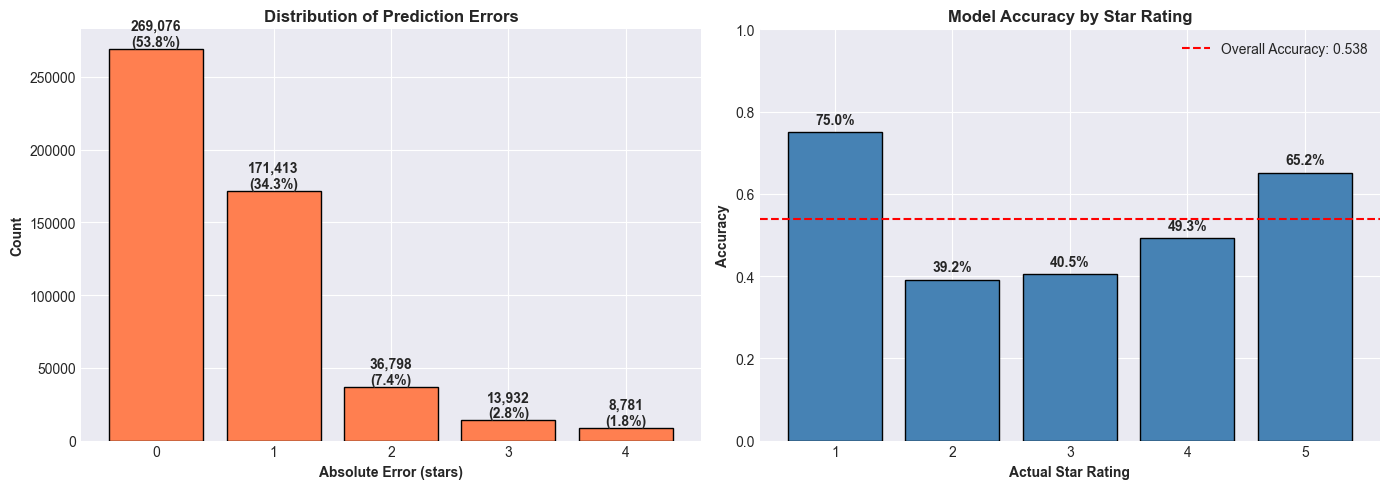

✓ Plot saved: 11_error_analysis.png


In [68]:
# Visualize error distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error magnitude distribution
error_counts = test_df_copy['abs_error'].value_counts().sort_index()
axes[0].bar(error_counts.index, error_counts.values, color='coral', edgecolor='black')
axes[0].set_xlabel('Absolute Error (stars)', fontweight='bold')
axes[0].set_ylabel('Count', fontweight='bold')
axes[0].set_title('Distribution of Prediction Errors', fontweight='bold')
axes[0].set_xticks([0, 1, 2, 3, 4])

# Add percentage labels
for i, (error, count) in enumerate(error_counts.items()):
    pct = count / len(test_df_copy) * 100
    axes[0].text(error, count, f'{count:,}\n({pct:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')

# Accuracy by star rating
accuracy_by_star = test_df_copy.groupby('actual')['correct'].mean()
axes[1].bar(accuracy_by_star.index, accuracy_by_star.values, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Actual Star Rating', fontweight='bold')
axes[1].set_ylabel('Accuracy', fontweight='bold')
axes[1].set_title('Model Accuracy by Star Rating', fontweight='bold')
axes[1].set_xticks([1, 2, 3, 4, 5])
axes[1].set_ylim(0, 1)
axes[1].axhline(y=gbm_accuracy, color='red', linestyle='--', 
               label=f'Overall Accuracy: {gbm_accuracy:.3f}')
axes[1].legend()

# Add percentage labels
for star, acc in accuracy_by_star.items():
    axes[1].text(star, acc + 0.02, f'{acc:.1%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../Outputs/Plots/11_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: 11_error_analysis.png")

## 11. Save Models and Results

In [69]:
# Save trained models
print("=" * 80)
print("SAVING MODELS AND RESULTS")
print("=" * 80)

print("\nSaving trained models...")

# Save models
with open('../Outputs/Models/rf_text.pkl', 'wb') as f:
    pickle.dump(rf_text, f)
print("Saved: rf_text.pkl")

with open('../Outputs/Models/rf_combined.pkl', 'wb') as f:
    pickle.dump(rf_combined, f)
print("Saved: rf_combined.pkl")

with open('../Outputs/Models/gbm.pkl', 'wb') as f:
    pickle.dump(gbm, f)
print("Saved: gbm.pkl")

# Save TF-IDF vectorizer
with open('../Outputs/Models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
print("Saved: tfidf_vectorizer.pkl")

# Save metadata encoders
with open('../Outputs/Models/metadata_encoders.pkl', 'wb') as f:
    pickle.dump(metadata_encoders, f)
print("Saved: metadata_encoders.pkl")

SAVING MODELS AND RESULTS

Saving trained models...
✓ Saved: rf_text.pkl
✓ Saved: rf_combined.pkl
✓ Saved: gbm.pkl
✓ Saved: tfidf_vectorizer.pkl
✓ Saved: metadata_encoders.pkl


In [70]:
# Save results summary
print("\nSaving results summary...")

# Create comprehensive results dictionary
results_summary = {
    'dataset_info': {
        'train_size': len(train_df),
        'test_size': len(test_df),
        'n_features_text': X_train_text.shape[1],
        'n_features_metadata': X_train_meta.shape[1],
        'n_features_total': X_train_combined.shape[1]
    },
    'baseline': {
        'accuracy': float(baseline_accuracy),
        'method': 'Most frequent class'
    },
    'random_forest_text': {
        'accuracy': float(rf_text_accuracy),
        'f1_macro': float(rf_text_f1_macro)
    },
    'random_forest_combined': {
        'accuracy': float(rf_combined_accuracy),
        'f1_macro': float(rf_combined_f1_macro)
    },
    'gradient_boosting': {
        'accuracy': float(gbm_accuracy),
        'f1_macro': float(gbm_f1_macro)
    },
    'metadata_improvement': float(metadata_improvement),
    'feature_importance': {
        'text_total': float(text_importance),
        'metadata_total': float(metadata_importance),
        'top_20_features': importance_df.head(20).to_dict('records')
    }
}

# Save as JSON
import json
with open('../Outputs/results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)
print("Saved: results_summary.json")

# Save results dataframe as CSV
results_df.to_csv('../Outputs/model_comparison.csv', index=False)
print("Saved: model_comparison.csv")

# Save per-class performance
per_class_df.to_csv('../Outputs/per_class_performance.csv', index=False)
print("Saved: per_class_performance.csv")

# Save error analysis
error_summary = test_df_copy[['text', 'actual', 'predicted', 'error', 'abs_error', 'word_count']]
error_summary.to_csv('../Outputs/error_analysis.csv', index=False)
print("Saved: error_analysis.csv")

print("\n" + "="*80)
print("ALL MODELS AND RESULTS SAVED SUCCESSFULLY")
print("="*80)


Saving results summary...
✓ Saved: results_summary.json
✓ Saved: model_comparison.csv
✓ Saved: per_class_performance.csv
✓ Saved: error_analysis.csv

ALL MODELS AND RESULTS SAVED SUCCESSFULLY
